In [64]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

import pandas as pd
import numpy as np
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import tqdm

This file aims to create TTV signals to validate 1st order MMR code with regimes
- Eccentricities: 0.001 to 0.1 / Uniform log e
- Longitudes of periastron: 0 to 360 deg / Uniform w
- MMRs: 2:1, 3:2, 4:3, 5:4 / Uniform
- Deltas: Depends on j, maximum 0.3 / Uniform
- Planet masses: 0.3 to 3000 Earth masses / Uniform log m

If system with invalid regime e >~ Delta^2 / mu is detected, then DO NOT SIMULATE.

In [65]:
# Evaluate Delta boundary for each j
def periodRatio(j):
    return j/(j-1)

def minmaxDelta(j):
    if j == 2:
        maxPeriodRatio = np.nan
        maxDelta = 0.3
    else:
        maxPeriodRatio = 0.5 * (periodRatio(j) + periodRatio(j-1))
        maxDelta = (j-1)/j * maxPeriodRatio - 1

    minPeriodRatio = 0.5 * (periodRatio(j) + periodRatio(j+1))
    minDelta = (j-1)/j * minPeriodRatio - 1
    
    return minDelta, maxDelta

minmaxDeltas = pd.DataFrame(
    [[j, *minmaxDelta(j)] for j in (2, 3, 4, 5)],
    columns=['j', 'min_Delta', 'max_Delta']
)

# Build lookup dictionaries once
minDelta_lookup = dict(zip(minmaxDeltas['j'], minmaxDeltas['min_Delta']))
maxDelta_lookup = dict(zip(minmaxDeltas['j'], minmaxDeltas['max_Delta']))

# Show df
minmaxDeltas.head()

,j,min_Delta,max_Delta
0,2,-0.125000,0.300000
1,3,-0.055556,0.166667
2,4,-0.031250,0.062500
3,5,-0.020000,0.033333


In [66]:
# Create 20000 samples
size = 20000
mstar = 1

e1 = 10 ** np.random.uniform(low=-3, high=-1, size=size)
e2 = 10 ** np.random.uniform(low=-3, high=-1, size=size)
w1 = np.random.uniform(low=0, high=360, size=size)
w2 = np.random.uniform(low=0, high=360, size=size)

j = np.random.choice([2, 3, 4, 5], size=size)
Delta_low = np.array(pd.Series(j).map(minDelta_lookup))
Delta_high = np.array(pd.Series(j).map(maxDelta_lookup))

Delta = np.random.uniform(low=Delta_low, high=Delta_high, size=size)
P1 = 7
P2 = P1 * (Delta + 1) * j / (j-1)

m1 = 10 ** np.random.uniform(low=-0.5, high=3.5, size=size)
m2 = 10 ** np.random.uniform(low=-0.5, high=3.5, size=size)

mu1 = (m1 * u.M_earth).to(mstar * u.M_sun).value
mu2 = (m2 * u.M_earth).to(mstar * u.M_sun).value

validity1 = Delta**2 / (mu1 * e1)
validity2 = Delta**2 / (mu2 * e2)
validity_threshold = 100

# Create valid mask
valid = (validity1 > validity_threshold) & (validity2 > validity_threshold)
valid_percent = valid.mean() * 100

# Compile to dataframe
df = pd.DataFrame({
    'e1': e1, 'w1': w1,
    'e2': e2, 'w2': w2,
    'Delta': Delta, 'j': j,
    'P1': 7, 'P2': P2,
    'm1': m1, 'm2': m2,
    'mu1': mu1, 'mu2': mu2,
    'validity1': validity1, 'validity2': validity2,
    'valid': valid
})
df.head()

,e1,w1,e2,w2,Delta,j,P1,P2,m1,m2,mu1,mu2,validity1,validity2,valid
0,0.053388,186.043895,0.076075,181.818531,0.222638,2,7,17.116927,12.834853,0.751828,0.000039,0.000002,24084.470880,288542.625443,True
1,0.008526,112.339563,0.097244,295.435382,-0.019897,4,7,9.147629,2.805066,7.676340,0.000008,0.000023,5511.286191,176.574558,True
2,0.086694,341.863230,0.025745,345.114473,0.023387,2,7,14.327417,1.389300,2.908286,0.000004,0.000009,1511.929506,2432.132277,True
3,0.002025,270.899942,0.005079,34.752301,-0.026923,3,7,10.217306,108.143864,0.980925,0.000325,0.000003,1102.314895,48442.003033,True
4,0.038375,219.897370,0.003113,257.231320,0.125581,3,7,11.818603,0.892786,60.379078,0.000003,0.000181,153257.722683,27934.018841,True


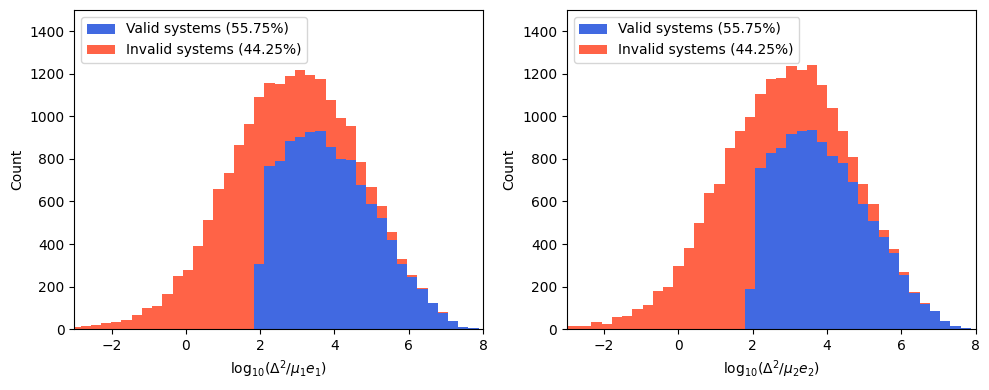

In [67]:
# Histogram of validity condition
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fmt = lambda x: f"{x:.2f}".rstrip("0").rstrip(".")
labels = [f"Valid systems ({fmt(valid_percent)}%)", f"Invalid systems ({fmt(100-valid_percent)}%)"]
colors = ["royalblue", "tomato"]
xlim = (-3, 8); ylim = (0, 1500)

# Left histogram
ax[0].hist([np.log10(validity1[valid]), np.log10(validity1[~valid])],
           bins=50, stacked=True, label=labels, color=colors)
ax[0].set_xlabel('log$_{10}$($\Delta^2 / \mu_1 e_1$)')
ax[0].set_ylabel('Count')
ax[0].set_xlim(xlim); ax[0].set_ylim(ylim)
ax[0].legend(loc='upper left')

# Right histogram
ax[1].hist([np.log10(validity2[valid]), np.log10(validity2[~valid])],
           bins=50, stacked=True, label=labels, color=colors)
ax[1].set_xlabel('log$_{10}$($\Delta^2 / \mu_2 e_2$)')
ax[1].set_ylabel('Count')
ax[1].set_xlim(xlim); ax[1].set_ylim(ylim)
ax[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [68]:
# Export dataframe
df.to_csv("lithwick_TTVFast_params.csv", index=False)